In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import OutfitsDataset
from models import *
from visualizations import plot_loss_curves, plot_roc_curve
from evaluate import compute_metrics

## Set DataLoaders

In [2]:
# Load dataframes
train_img = pd.read_csv('Normal_Outfits_Data/train4siamese.csv')
test_img = pd.read_csv('Normal_Outfits_Data/test4siamese.csv')
train_desc = pd.read_csv('train4clip.csv')
test_desc = pd.read_csv('test4clip.csv')

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, saturation=0.5),
    transforms.ToTensor()
])

# Create datasets
train_dataset = OutfitsDataset(train_img, train_desc, transform=train_transform)
test_dataset = OutfitsDataset(test_img, test_desc, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Define MultiModalPredictor

In [3]:
class GatedMultimodalUnit(nn.Module):
    def __init__(self, hidden_dim):
        super(GatedMultimodalUnit, self).__init__()
        self.visual_fc = nn.Linear(1920, hidden_dim)
        self.textual_fc = nn.Linear(2560, hidden_dim)
        self.attribute_fc = nn.Linear(850, hidden_dim)

        self.gate_visual = nn.Linear(1920, hidden_dim)
        self.gate_textual = nn.Linear(2560, hidden_dim)
        self.gate_attribute = nn.Linear(850, hidden_dim)

    def forward(self, visual_features, textual_features, attributes):
        visual_h = torch.tanh(self.visual_fc(visual_features))
        textual_h = torch.tanh(self.textual_fc(textual_features))
        attribute_h = torch.tanh(self.attribute_fc(attributes))

        visual_gate = torch.sigmoid(self.gate_visual(visual_features))
        textual_gate = torch.sigmoid(self.gate_textual(textual_features))
        attribute_gate = torch.sigmoid(self.gate_attribute(attributes))

        combined_features = visual_gate * visual_h + textual_gate * textual_h + attribute_gate * attribute_h
        return combined_features

class MultiModalGMUPredictorVC(nn.Module):
    def __init__(self, weights_path='best_model.pt'):
        super(MultiModalGMUPredictorVC, self).__init__()
        self.visual_model = VisualFeatureExtractor().cuda()
        self.textual_model = TextualFeatureExtractor().cuda()
        self.attribute_model = AttributeModel().cuda()
        self.d_model = 2048
        self.gmu = GatedMultimodalUnit(self.d_model)
        self.__set_visual_model(weights_path)
        
        self.fc = nn.Sequential(
            nn.Linear(self.d_model, 1024),
            nn.LayerNorm(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
        self.dropout = nn.Dropout(0.5)
    
    def __set_visual_model(self, weights_path):
        # load the pretrained weights trained for binary classification
        weights = torch.load(weights_path)
        
        # remove the final classification layers
        weights_to_remove = ["fc.0.weight", "fc.0.bias", "fc.1.weight", "fc.1.bias", "fc.4.weight", "fc.4.bias"]
        for k in weights_to_remove:
            weights.pop(k)

        self.visual_model.load_state_dict(weights)
    
    def forward(self, imgs, texts):
        img_features = self.visual_model(imgs)
        text_features = self.textual_model(texts)
        attributes = self.attribute_model(imgs)

        # pass through GMU
        all_features = self.gmu(img_features, text_features, attributes)
        
        output = self.fc(all_features)
        
        return output

## Training

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MultiModalGMUPredictorVC().to(device)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [5]:
# Training and validation loop
num_epochs = 10
train_losses = []
val_losses = []
best_acc = 0.7

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for img_inputs, text_inputs, labels in tqdm(train_loader):
        img_inputs = [part.to(device) for part in img_inputs]
        text_inputs = text_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(img_inputs, text_inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for img_inputs, text_inputs, labels in test_loader:
            img_inputs = [part.to(device) for part in img_inputs]
            text_inputs = text_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(img_inputs, text_inputs).squeeze()
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * labels.size(0)
            preds = (outputs > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

        val_loss = val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val /  total_val

    if val_accuracy >= best_acc:
        torch.save(model.state_dict(), 'best_vca_gmu.pt')
        best_acc = val_accuracy
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 822/822 [18:07<00:00,  1.32s/it]


Epoch 1/10, Train Loss: 0.6987, Train Accuracy: 0.5049, Val Loss: 0.6859, Val Accuracy: 0.5979


100%|████████████████████████████████████████████████████████████████████████████████| 822/822 [12:40<00:00,  1.08it/s]


Epoch 2/10, Train Loss: 0.6398, Train Accuracy: 0.6361, Val Loss: 0.6341, Val Accuracy: 0.6318


100%|████████████████████████████████████████████████████████████████████████████████| 822/822 [12:33<00:00,  1.09it/s]


Epoch 3/10, Train Loss: 0.5687, Train Accuracy: 0.7138, Val Loss: 1.0593, Val Accuracy: 0.5000


100%|████████████████████████████████████████████████████████████████████████████████| 822/822 [12:28<00:00,  1.10it/s]


Epoch 4/10, Train Loss: 0.5358, Train Accuracy: 0.7386, Val Loss: 0.6740, Val Accuracy: 0.6603


100%|████████████████████████████████████████████████████████████████████████████████| 822/822 [12:31<00:00,  1.09it/s]


Epoch 5/10, Train Loss: 0.5163, Train Accuracy: 0.7531, Val Loss: 0.7371, Val Accuracy: 0.5729


100%|████████████████████████████████████████████████████████████████████████████████| 822/822 [12:31<00:00,  1.09it/s]


Epoch 6/10, Train Loss: 0.5078, Train Accuracy: 0.7566, Val Loss: 0.7888, Val Accuracy: 0.6832


100%|████████████████████████████████████████████████████████████████████████████████| 822/822 [12:31<00:00,  1.09it/s]


Epoch 7/10, Train Loss: 0.5011, Train Accuracy: 0.7617, Val Loss: 0.9270, Val Accuracy: 0.5781


100%|████████████████████████████████████████████████████████████████████████████████| 822/822 [12:32<00:00,  1.09it/s]


Epoch 8/10, Train Loss: 0.4898, Train Accuracy: 0.7706, Val Loss: 0.6443, Val Accuracy: 0.6223


100%|████████████████████████████████████████████████████████████████████████████████| 822/822 [12:42<00:00,  1.08it/s]


Epoch 9/10, Train Loss: 0.4751, Train Accuracy: 0.7820, Val Loss: 0.6017, Val Accuracy: 0.6764


100%|████████████████████████████████████████████████████████████████████████████████| 822/822 [12:49<00:00,  1.07it/s]


Epoch 10/10, Train Loss: 0.4685, Train Accuracy: 0.7855, Val Loss: 0.7992, Val Accuracy: 0.6918


## Visualize Training

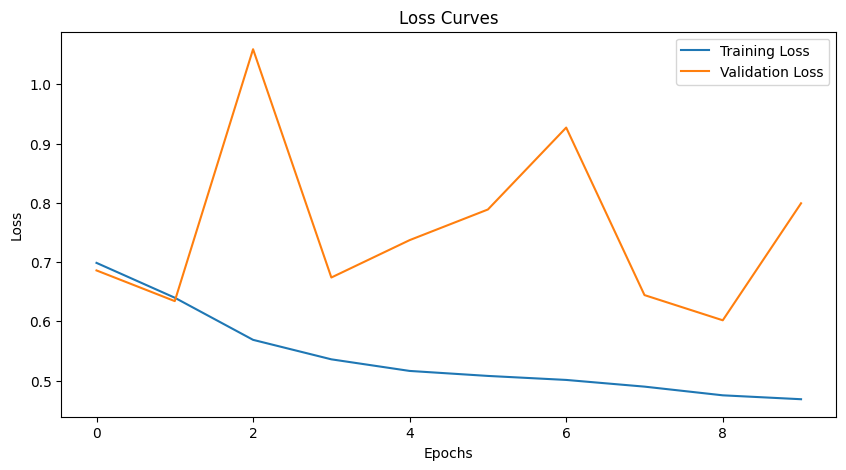

In [6]:
# plot learning curves
plot_loss_curves(train_losses, val_losses)

## Evaluate

In [8]:
import numpy as np

In [9]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for img_inputs, text_inputs, labels in tqdm(test_loader):
        img_inputs = [part.to(device) for part in img_inputs]
        text_inputs = text_inputs.to(device)
        labels = labels.to(device)
        outputs = model(img_inputs, text_inputs)
        preds = outputs.cpu().numpy()  # Assuming a sigmoid activation for binary classification
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [01:02<00:00,  1.48it/s]


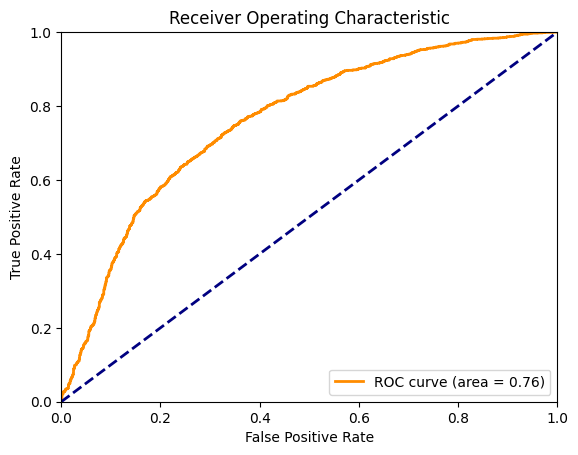

In [10]:
# plot ROC curve
plot_roc_curve(all_labels, all_preds)

In [11]:
metrics = compute_metrics(all_labels, all_preds)
print(metrics)

{'auc': 0.7595550290861325, 'accuracy': 0.6917808219178082, 'precision': 0.6590909090909091, 'recall': 0.7945205479452054, 'f1_score': 0.7204968944099379}
